<a href="https://colab.research.google.com/github/geneginseng/Status/blob/main/status_parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read before running

If you haven't uploaded web pages to Google Drive, set upload_web_page_to_drive to True. If you haven't uploaded json files to Google Drive, set upload_json_to_drive to True.

In [1]:
upload_web_page_to_drive = False
upload_json_to_drive = False

Please provide the URLs of web pages along with the corresponding data, specify the folder's ID and name on Google Drive where the web pages should be stored. Additionally, indicate the prefix for the file titles when uploading web pages. Also, specify the ID and name of the folder on Google Drive where the processed web pages will be stored as JSON files. Ensure that the required folders are pre-created within the 'My Drive' parent directory.



In [2]:
base_url = 'https://echofm.online/programs/status/status-s-ekaterinoj-shulman-'
urls = [f'{base_url}{episode_number}' for episode_number in range(1,73)]
pages_folder_id = '179qr6SD9Y2A8jrKsiH9RKnAplW0G4ST9'
pages_folder_name = 'Episodes'
page_file_title = 'episode_'
json_folder_id = '17s7434iNxvPDyn4wTOLDzyDfX-4XMAEV'
json_folder_name = 'Episodes json'

Before 'Uploading web pages to Google Drive' step Mount Drive in the left sidebar (Files -> Mount Drive).

# Installing Python modules and libraries

In [3]:
!pip install requests
!pip install beautifulsoup4
!pip install dataclasses_json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.5 MB/s eta 0:00:00


# Authentication in Google Drive

In [4]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [5]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Defining the function for uploading files to Google Drive

In [6]:
def upload_to_folder(folder_id, file_title, mimeType, text, number='') -> None:
  metadata = {
      'parents': [
          {"id": folder_id}
      ],
      'title': f'{file_title}{number}',
      'mimeType': f'{mimeType}'
  }
  file = drive.CreateFile(metadata=metadata)
  file.SetContentString(text)
  file.Upload()

# Uploading web pages to Google Drive

In [7]:
import requests
import time
from tqdm import tqdm

In [8]:
if upload_web_page_to_drive:
  for url in tqdm(urls):
    try:
      r = requests.get(url)
      text = r.text
      number = url.removeprefix(base_url)
      upload_to_folder(pages_folder_id, page_file_title, 'text/plain', text, number)
      time.sleep(1)
    finally:
      continue

# Handling uploaded web pages

In [9]:
try:
    from BeautifulSoup import BeautifulSoup
except ImportError:
    from bs4 import BeautifulSoup

In [10]:
from dataclasses import dataclass, field
from dataclasses_json import dataclass_json

@dataclass_json
@dataclass
class Data:
  """Class for storing utterances of speakers"""
  speaker: int
  text: str

@dataclass_json
@dataclass
class Episode:
  """Class for storing utterances content"""
  title: str
  date: str
  number: int|str
  speakers: list[str] = field(default_factory=list)
  data: list[Data] = field(default_factory=list)

In [11]:
from sys import base_prefix
from dataclasses_json import dataclass_json
import re

def remove_speaker_name(text: str) -> str:
  name_and_utterance_lst = list(filter(None,
                                       re.split(r'([А-Я][.][А-Я]+[:][ ])',
                                                text, 1)))
  if len(name_and_utterance_lst) == 2:
    text = name_and_utterance_lst[1]
  return text

def create_episode(file: str) -> Episode:
  text = ''
  with open(f'/content/drive/My Drive/{pages_folder_name}/{file}', 'r') as f:
    text = f.read()
    number = file.removeprefix(page_file_title)
  parsed_html = BeautifulSoup(text)
  article = parsed_html.body.find('article',
                                  attrs={'class':'wp-embed-responsive'})

  title = article.find('h1').text

  div1 = article.find('div', {'class':'sc-1f63cf03-6 cJndFP'})
  div2 = div1.find('div', {'class':'sc-1f63cf03-7 gBakUU'})
  date = div2.find('span').text

  episode = Episode(title, date, number)

  paragraphs = article.find_all('p')

  speaker_id = -1
  pattern = '([А-Я][.][А-Я]+)'
  prog = re.compile(pattern)

  for paragraph in paragraphs:
    # if speaker is defined in this paragraph set it as a current speaker
    s = paragraph.find('strong')
    b = paragraph.find('b')
    if s is not None or b is not None:
      if s is not None:
        paragraph_with_speaker = s.text
      elif b is not None:
        paragraph_with_speaker = b.text
      match = prog.match(paragraph_with_speaker)
      speaker = match.group(0)

      if match:
        if speaker not in episode.speakers:
          episode.speakers.append(speaker)
        speaker_id = episode.speakers.index(speaker)

    # if there is no current speaker go to the next iteration
    if speaker_id < 0:
      continue

    # add the speaker's utterance to the episode's content
    text = remove_speaker_name(paragraph.text)
    utterance = Data(speaker_id, text)
    episode.data.append(utterance)

  return episode

# Converting processed web pages to JSON format and uploading them to Google Drive

In [12]:
if upload_json_to_drive:
  import os
  from tqdm import tqdm
  import json
  path = f'/content/drive/MyDrive/{pages_folder_name}'
  files = os.listdir(path)
  for file in tqdm(files):
    try:
      episode = create_episode(file)
      json_episode = episode.to_json(ensure_ascii=False)
      upload_to_folder(json_folder_id,
                       file,
                       'text/plain',
                       json_episode)
    except AttributeError as e:
      print(e)

# Creating bar charts using Matplotlib and Plotly libraries

In [13]:
import os
from tqdm import tqdm
import json
from dataclasses_json import dataclass_json
import numpy as np
import pandas as pd

In [14]:
path = f'/content/drive/MyDrive/{json_folder_name}'
files = os.listdir(path)
all_episodes_stat = list()
for file in tqdm(files):
  try:
    with open(f'{path}/{file}', 'r') as f:
      dict_with_data = json.load(f)
      episode = Episode.from_dict(dict_with_data)
      stat = dict()
      stat['episode_number'] = episode.number
      stat['episode_date'] = episode.date
      stat['speakers'] = dict()
      stat['all'] = 0
      for utterance in episode.data:
        speaker = episode.speakers[utterance.speaker]
        if stat['all'] == 0:
          stat['all'] =  len(utterance.text.split())
        else:
          stat['all'] +=  len(utterance.text.split())
        if speaker not in stat['speakers'].keys():
          stat['speakers'][speaker] =  len(utterance.text.split())
        else:
          stat['speakers'][speaker] +=  len(utterance.text.split())
      all_episodes_stat.append(stat)
  except:
    pass

100%|██████████| 37/37 [00:08<00:00,  4.29it/s]


In [99]:
import matplotlib.pyplot as plt

In [100]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), fontsize="4", loc ="upper left")

def create_bar_chart(all_stat):
  all_stat = [x for x in all_stat if len(x['speakers'].keys())>0]

  X = [f"от {episode['episode_date']}" for episode in all_stat]
  X_axis_range = np.arange(len(X))
  X_axis_range_iterator = iter(X_axis_range)
  width = 0.5  # the width of the bars
  multiplier = 0
  color = ['purple', 'blue', 'lightblue', 'red', 'black']
  fig, ax = plt.subplots(figsize=(14.4, 4.8))
  count = 0
  for stat in all_stat:
    speakers = [key for key in stat['speakers'].keys()]
    count+=1
    bar_height = [round(stat['speakers'][speaker]/stat['all']*100, 1) for speaker in speakers]

    next_x_axis = next(X_axis_range_iterator)
    offsets = [(next_x_axis + width*num) for num in range(0, (len(speakers)))]
    bar = ax.bar(offsets,
                 bar_height,
                 width,
                 color=color[:len(speakers)],
                 label=speakers,
                 edgecolor='white')
    multiplier += 1

  ax.set_ylabel("Доля (%)", fontsize="8")
  ax.set_xlabel("Эпизоды", fontsize="8")
  ax.set_title("Процентное отношение высказываний спикеров программы 'Статус'", fontsize="8")
  ax.set_xticks(X_axis_range+width/2, X)
  plt.xticks(rotation=90)
  ax.tick_params(axis='both', which='major', labelsize=6)
  ax.tick_params(axis='both', which='minor', labelsize=4)
  ax.spines['top'].set_color('#DDDDDD')
  ax.spines['right'].set_color('#DDDDDD')
  ax.spines['left'].set_color('#DDDDDD')
  ax.spines['bottom'].set_color('#DDDDDD')
  ax.tick_params(bottom=False, left=False)
  ax.set_axisbelow(True)
  ax.yaxis.grid(True, color='#EEEEEE')
  ax.xaxis.grid(False)
  ax.autoscale(enable=True, axis='x', tight=True)
  for bar in ax.patches:
    bar_value = bar.get_height()
    text = f'{bar_value}%'
    text_x = bar.get_x() + bar.get_width() / 2
    text_y = bar.get_y() + bar_value
    bar_color = bar.get_facecolor()
    ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
          size=6, fontweight='extra bold')
  legend_without_duplicate_labels(ax)
  plt.show()

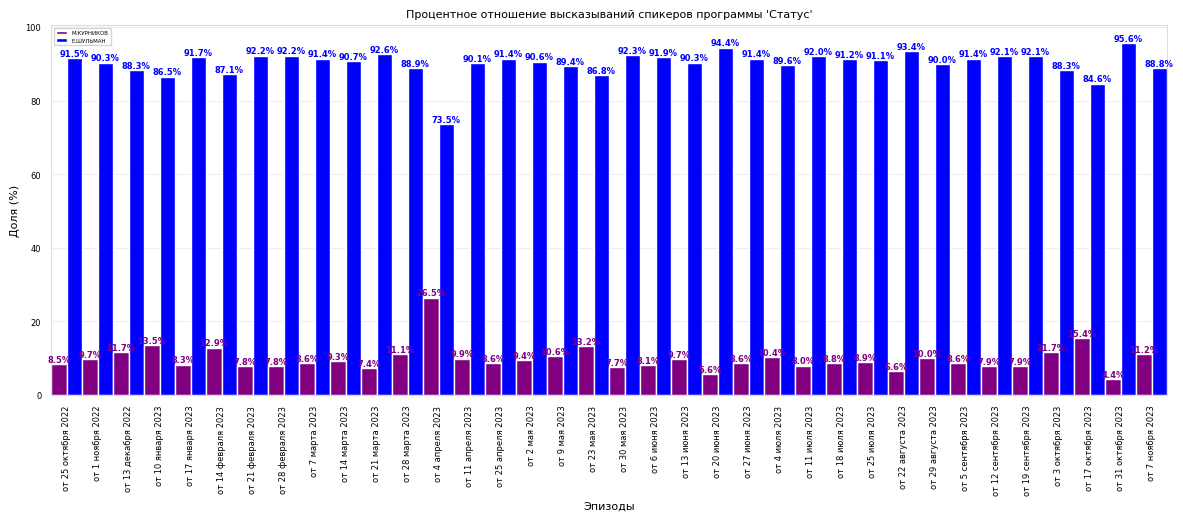

In [101]:
create_bar_chart(all_episodes_stat)

In [102]:
import plotly.express as px

In [103]:
all_stat = [x for x in all_episodes_stat if len(x['speakers'].keys())>0]
speakers = list()
[speakers.extend(x) for x in [x['speakers'].keys() for x in all_stat]]
speakers = list(set(speakers))
df = pd.json_normalize(all_stat)
for speaker in speakers:
  df.rename(columns = {f"speakers.{speaker}":speaker}, inplace = True)

In [104]:
fig = px.bar(df,
             x="episode_date",
             y=speakers,
             title="Процентное отношение высказываний спикеров программы 'Статус'",
             labels={"value": "Доля (%)", "variable": "Спикер", "episode_date": "Эпизоды"},
             template="simple_white"
            )
#fig.update_traces(textposition='inside')
fig.update_layout(showlegend=True,
                  barnorm="percent",
                  autosize=True,
                  bargap=0,
                  font_family="arial",
                  font_size=10)
fig.show()